In [2]:
from IPython.display import HTML
from IPython.display import Image

# Deploying Glaucoma Keras Model Using Amazon SageMaker


<img src='eye-model.png' width="1000" height="300" align="left">

**By: Pieter Leffers**

*Completion Date: June 3, 2019*

Now that the Keras model has been been trained and saved its time to deploy the model for use. Although you may use flask and a web framework from scratch to deploy the model; however, doing so would be beyond the scope of this project for sure. For ease and simplicity AWS Sagemaker is a good choice, but I have found during the course of this project that although Sagemaker makes it easy to host and deploy your models, the documentation on doing so isn't necessarily good and doesn't have the ease of functionality that I would prefer. Fortunately for others whom have trained their own models in Keras, you can follow this notebook to deploy a model and create a Sagemaker endpoint in order to connect to a web framework and start running inferencing on batches of data.


*Note: If you haven't gone through my previous project notebook on creating and training the glaucoma model; you will need to know that your trained model will need to be saved in the Keras JSON and weights hdf5 format. The Keras JSON file will contain your model architecture and the hdf5 will contain your model weights.*

**Start Sagemaker Instance**

<img src='sage1.png' width="1000" height="300" align="left">

Click on **'Create notebook instance'** and provide the details needed to start the instance. For my needs I started an **ml.m4.xlarge** instance since which has 4 virtual cpus and 16 gigs of ram, which is fairly equivalent to my local computer architecture.

<img src='sage2.png' width="1000" height="300" align="left">



In the AWS Management Console, go to the Amazon SageMaker console and choose a *'Notebook Instance'*, as opposed to a *'Jupyter Lab'* instance and create a new notebook instance. Using the 'Upload' button, upload my notebook from my github set the kernel to **conda_tensorflow_p36**.


<img src='sage3.png' width="300" height="300" align="left">

<img src='sage4.png' width="500" height="300" align="left">

Calling the get_execution_role function retrieves the AWS Identity and Access Management (IAM) role created at the time of creating the notebook instance. Here I am storing the execution_role in the variable name *role*.

In [1]:
import boto3, re
from sagemaker import get_execution_role

role = get_execution_role()

In [2]:
import keras
from keras.models import model_from_json

Using TensorFlow backend.


Create a directory called keras_model.

In [3]:
!mkdir keras_model

Then navigate to the 'Home' tab and choose 'Open JupyterLab'. 

<img src='sage3.png' width="300" height="300" align="left">

Once JupyterLab is open click on the up arrow on the left-hand menu and upload the **glaucoma_model_architecture.json**, **glaucoma_model_weights.h5**, **5.png**, and **11.png** files.

<img src='sage5.png' width="500" height="300" align="left">

*Note: the reason you switch to JupyterLab is because the model **glaucoma_model_weights.h5** file returns a file size warning which the original notebook will fail to provide. Be aware that because of the size and the error, the **glaucoma_model_weights.h5** file may need to be uploaded multiple times. I have also found that it takes a few minutes to load so I would recommend to be patient here. Also I am primarily choosing to work in Jupyter Notebook as opposed to JupyterLab because I have found the Notebook to be more stable.*

<img src='sage6.png' width="500" height="300" align="left">

Now you can return to the original notebook instance and run the code in the cell below to see that those files are present. 

In [4]:
!ls keras_model

**Now upload we can upload the model files into Sagemaker**

Note: ignore the warning.

In [5]:
json_file = open('/home/ec2-user/SageMaker/keras_model/'+'glaucoma_model_architecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

Instructions for updating:
Colocations handled automatically by placer.


*Note: this portion will also take a few minutes to load*

In [7]:
loaded_model.load_weights('/home/ec2-user/SageMaker/keras_model/glaucoma_model_weights.h5')
print("Loaded model from disk")

Loaded model from disk


### Export the Keras model to the TensorFlow ProtoBuf format

In [8]:
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

The directory structure outlined below will need to be followed exactly.

In [9]:
model_version = '1'
export_dir = 'export/Servo/' + model_version

In [10]:
# Build the Protocol Buffer SavedModel at 'export_dir'
builder = builder.SavedModelBuilder(export_dir)

Note: ignore the warning

In [11]:
# Create prediction signature to be used by TensorFlow Serving Predict API
signature = predict_signature_def(
    inputs={"inputs": loaded_model.input}, outputs={"score": loaded_model.output})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


**Start a Keras Session**

In [12]:
from keras import backend as K

with K.get_session() as sess:
    # Save the meta graph and variables
    builder.add_meta_graph_and_variables(
        sess=sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
    builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: export/Servo/1/saved_model.pb


### Convert TensorFlow model to a SageMaker readable format

Move the TensorFlow exported model into the directory export\Servo\. SageMaker will recognize this as a loadable TensorFlow model. Your directory and file structure should look like: 

    export/Servo/1/
    variables.data-00000-of-00001  variables.index

In [13]:
!ls export

Servo


In [14]:
!ls export/Servo

1


In [15]:
!ls export/Servo/1

saved_model.pb	variables


In [16]:
!ls export/Servo/1/variables

variables.data-00000-of-00001  variables.index


####  Tar the entire directory and upload to S3

In [17]:
import tarfile
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

In [18]:
import sagemaker

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

### Deploy the trained model

*Note: The entry_point file "train.py" can be an empty Python file.* 

In [19]:
!touch train.py

Now start *TensorFlowModel* function, using the parameters below.

*Note: I followed the warning below using "py_version='py3'" and the instance wouldn't start. So I would recommend leaving the option at python 2.7 for now.*

In [20]:
from sagemaker.tensorflow.model import TensorFlowModel
sagemaker_model = TensorFlowModel(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                                  role = role,
                                  framework_version = '1.12',
                                  entry_point = 'train.py')

The Python 2 tensorflow images will be soon deprecated and may not be supported for newer upcoming versions of the tensorflow images.
Please set the argument "py_version='py3'" to use the Python 3 tensorflow image.


Now deploy the algorithm to the instance. This will take quite awhile so you will need to relax until it completes without interrupting anything.

In [21]:
%%time
predictor = sagemaker_model.deploy(initial_instance_count=1,
                                   instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------------------------------!CPU times: user 582 ms, sys: 37.3 ms, total: 619 ms
Wall time: 8min 22s


You will need to update the endpoint in the cell below with the endpoint name from the output of the previous cell. You can simply navigate to the Sagemaker console, click on 'Endpoints' and copy the 'Name' in the box. Then paste it in the cell below.

<img src='sage7.png' width="500" height="300" align="left">

In [22]:
endpoint_name = 'sagemaker-tensorflow-2019-06-03-21-51-31-059'

Now we can set the TensorFlowPredictor to the endpoint

In [23]:
import sagemaker
from sagemaker.tensorflow.model import TensorFlowModel
predictor=sagemaker.tensorflow.model.TensorFlowPredictor(endpoint_name, sagemaker_session)

###  Invoking the endpoint

Now I that I have all the pieces in place I want to make sure that the predicor function can properly make predictions from the algorithm.

Import packages

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing.image import load_img
from keras.models import load_model
from keras.preprocessing import image
import pandas as pd
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

Load image function to prepare an image into tensor format

In [25]:
def load_image(img_path, show=False):
    # (height, width, channels)
    img = image.load_img(img_path, target_size=(64, 64))
    # (1, height, width, channels), add a dimension because the model expects this shape:
    # (batch_size, height, width, channels)
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    # imshow expects values in the range [0, 1]
    img_tensor /= 255.                                      

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

Set the path to the image files we uploaded before. These images come from the validation set, which isn't stricly kosher, but this is more for demonstration purposes. 

In [ ]:
# image path
img_path_case = '/home/ec2-user/SageMaker/keras_model/11.png'    
img_path_control = '/home/ec2-user/SageMaker/keras_model/5.png'    

#### Invoke the load_image function and invoke the SageMaker endpoint from the notebook

In [30]:
# load a single image
new_image = load_image(img_path_case)

# check prediction
pred = predictor.predict(new_image)

From the results below (float_val) we can see we are 0.99976 sure that the image is a case of Glaucoma vs. 0.00233 sure that we are dealing with a normal retina image.


In [31]:
pred

{'outputs': {'score': {'dtype': 1,
   'tensor_shape': {'dim': [{'size': 1}, {'size': 2}]},
   'float_val': [0.9976667165756226, 0.0023333081044256687]}},
 'model_spec': {'name': 'generic_model',
  'version': {'value': 1},
  'signature_name': 'serving_default'}}

Here's what the image looks like...

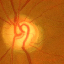

In [32]:
image = load_img(img_path_case, target_size=(64, 64))
image

*...If you are following along with this notebook, try changing the example image to **'img_path_control'** and see how the prediction changes.*

#### Invoke the SageMaker endpoint using a boto3 client

Here we can see the endpoint is live and can serve predictions.

In [38]:
import json
import boto3
import numpy as np
import io
 
client = boto3.client('runtime.sagemaker')
# The sample model expects an input of shape [1,50]
data = new_image.tolist()
response = client.invoke_endpoint(EndpointName=endpoint_name, Body=json.dumps(data))
response_body = response['Body']
print(response_body.read())

b'{\n  "outputs": {\n    "score": {\n      "dtype": "DT_FLOAT", \n      "floatVal": [\n        0.9976667165756226, \n        0.0023333081044256687\n      ], \n      "tensorShape": {\n        "dim": [\n          {\n            "size": "1"\n          }, \n          {\n            "size": "2"\n          }\n        ]\n      }\n    }\n  }, \n  "modelSpec": {\n    "version": "1", \n    "name": "generic_model", \n    "signatureName": "serving_default"\n  }\n}'


### Conclusion

Now that the algorithm has been fully deployed to an AWS endpoint and can serve predictions I have finally chosen to close down the endpoint and delete all of the resources in order to avoid any unecessary charges since this has been primarily for demonstration purposes. However, if this was in a full production environment you could in theory, easily connect the AWS endpoint to your web application or web framework to host the algorithm and pass data through it in order to get predictions. That being said, this is about as far as I can take this project without creating a whole web-application / front-end for a data pipeline; which would involve a number of skills normally outside of the Data Science spectrum. 

*So what have I demonstrated throughout this project?*

We have seen the entire life-cycle of an algorithm from doing background research, to development and training of a model, to final deployment of a model to a space where it can serve predictions on a dataset. Just like in most  scientific work I would say that at each point of the project there are places to improve; from background research all the way to deployment. However, I feel for the purposes of this project things are at a fairly complete stage without spending unfortunate amounts of hours without spinning my wheels refining details. We have seen the algorithm has at least a 90% accuracy, which means that 9 out of 10 times when the algorithm makes a prediction, it is an accurate prediction. I think it should be abundantly clear that I never intend for these predictions to replace an opthimologist's diagnosis, but it may perhaps to be useful for diagnostic purposes which is the best I could hope for.  